# Workfunction of hcp (0001) surfaces

In this notebook, we will show how to calculate the workfunction of selected hcp(0001) surfaces using [VASP](https://www.vasp.at/). Please keep in mind that the parameters used here give no converged results. They have been chosen to demonstrate the workflow using inexpensive calculations. For converged results, parameters such as lattice parameters, plane-wave energy cutoffs, reciprocal space sampling or the need to perform spin polarized calculations have to be carefully chosen 

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
import pandas as pd
import time

In [2]:
from pyiron import Project

In [3]:
pr = Project("hcp_workfunction")

## Calculating the Workfunction of Mg(0001) 

### Structure creation
We use the `create_surface()` function which uses the ASE surface generator to build our surface slab structure

In [4]:
 # Now we set-up the Mg (0001) surface
a = 3.1919
c = 5.1852

# Vacuum region to break the periodicity along the z-axis
vac = 10
size = (2, 2, 4)
Mg_0001 = pr.create_surface("Mg", 
                            surface_type="hcp0001", 
                            size=size, 
                            a=a, 
                            c=c, 
                            orthogonal=True, 
                            vacuum=vac)
Mg_0001.plot3d()

NGLWidget()

### Using selective dynamics

We use selective dynamics to restrict relaxation to the surface atoms (first and last Mg layers). We use the advanced array indexing options available in the NumPy package (see [here](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html)) to detect which atoms are at the surface and then freeze the rest

In [5]:
# Initially freeze all the atoms
Mg_0001.add_tag(selective_dynamics=[False, False, False])

# Find which atoms are at the surface 
# (based on the z-coordinate)
pos_z = Mg_0001.positions[:, 2]
z_min, z_max = np.min(pos_z), np.max(pos_z)
eps = 1e-4
relax_indices = np.argwhere(((pos_z - eps) > z_min) 
                            & ((pos_z + eps) < z_max ))
relax_indices  = relax_indices.flatten()

# Now allow these atoms to relax

Mg_0001.selective_dynamics[relax_indices] = [True, True, True]

### Setup and execution

To automate the calculation we define a function that has as input the project object, structure, job_name, Fermi smearing width, the type of k-point sampling and the plane-wave energy cutoff

In [6]:
def get_ham(proj, basis, name, sigma=0.1, mesh="GP", encut=350):
    ham = proj.create_job(pr.job_type.Vasp, name)
    ham.set_convergence_precision(electronic_energy=1e-7, 
                                  ionic_energy=1e-2)
    # Setting fermi-smearing
    ham.set_occupancy_smearing(smearing="fermi", width=sigma)
    # Ionic_minimization
    ham.calc_minimize(ionic_steps=100, 
                      electronic_steps=60, 
                      retain_electrostatic_potential=True, 
                      pressure=None)
    ham.structure = basis
    ham.set_encut(encut=encut)
    if mesh == "GP":
        # Only the Gamma point
        ham.set_kpoints(scheme="GP")
    elif len(mesh) == 3:
        ham.set_kpoints(mesh=mesh)
    return ham

In [7]:
ham_vasp = get_ham(proj=pr, 
                   basis=Mg_0001, 
                   name="Mg_0001", 
                   sigma=0.1, 
                   mesh="GP", 
                   encut=350)

### Submitting to the queue (optional)

If you use a cluster installation of pyiron, you can send the created jobs to the cluster by specifying the name of the queue and the number of cores

In [8]:
# queue = ham_vasp.server.list_queues()[-1]
# ham_vasp.server.queue = queue
# ham_vasp.server.cores = 20


### Choosing an appropriate executable

In [9]:
ham_vasp.executable.available_versions

['5.3',
 '5.3_col',
 '5.3_col_mpi',
 '5.3_mpi',
 '5.4',
 '5.4.4',
 '5.4.4_gam',
 '5.4.4_gam_mpi',
 '5.4.4_mpi',
 '5.4.4_ncl',
 '5.4.4_ncl_mpi',
 '5.4.4_std',
 '5.4.4_std_mpi',
 '5.4_gamma',
 '5.4_gamma_mpi',
 '5.4_mpi']

Since this example uses the $\Gamma$ point only, we can use the VASP Gamma-only version. If you use more k-points choose an appropriate executable

In [10]:
ham_vasp.executable.version = "5.4_gamma"

### Execution

The job is ready for execution

In [11]:
ham_vasp.run()

### Post processing

To analyze the results we ensure that the job is finished (the `if` statement in the first line). We then compute the work function by subtracting the Fermi-level from the vacuum level

$\Phi = V_{vac} - \epsilon_F$

wf: 3.37343565133


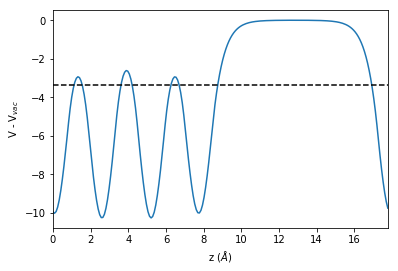

In [12]:
if ham_vasp.status.finished:
    # Get the electrostatic potential
    epot = ham_vasp.get_electrostatic_potential()
    
    # Compute the lateral average along the z-axis (ind=2)
    epot_z = epot.get_average_along_axis(ind=2)
    
    # Get the final relaxed structure from the simulation
    struct = ham_vasp.get_structure(iteration_step=-1)
    r = np.linalg.norm(struct.cell[2])
    z = np.linspace(0, r, len(epot_z))
    
    # Computing the vacuum-level
    vac_level = np.max(epot_z)
    
    # Get the electronic structure
    es = ham_vasp.get_electronic_structure()
    print("wf:", vac_level - es.efermi)
    plt.plot(z, epot_z - vac_level)
    plt.xlim(0, r)
    plt.axhline(es.efermi - vac_level,
                color="black", 
                linestyle="dashed")
    plt.xlabel("z ($\AA$)")
    plt.ylabel("V - V$_{vac}$");

## Looping over a series of hcp(0001) surfaces

We now repeat the workflow for a set of hcp metals (the chosen lattice parameters are approximate). Note that if you use the same naming convention, pyiron detects that a job with the same name exists ("Mg_0001") and loads the output from this calculation rather than launch a new job with the same name.

In [13]:
hcp_dict = {"Zn": {"a":2.6649, "c": 4.9468}, 
            "Mg": {"a": 3.1919, "c": 5.1852}, 
            "Co": {"a": 2.5071 , "c": 4.0695},
            "Ru": {"a": 2.7059 , "c": 4.2815}}

In [14]:
vac = 10
size = (2, 2, 4)
for element, lattice_parameters in hcp_dict.items():
    surf = pr.create_surface(element, 
                             surface_type="hcp0001", 
                             size=size, 
                             a=lattice_parameters["a"], 
                             c=lattice_parameters["c"], 
                             orthogonal=True, vacuum=vac)
    surf.add_tag(selective_dynamics=[False, False, False])
    pos_z = surf.positions[:, 2]
    z_min, z_max = np.min(pos_z), np.max(pos_z)
    eps = 1e-4
    relax_indices = np.argwhere(((pos_z - eps) > z_min) 
                                & ((pos_z + eps) < z_max ))
    relax_indices  = relax_indices.flatten()
    surf.selective_dynamics[relax_indices] = [True, True, True]
    job_name = "{}_0001".format(element)
    ham = get_ham(pr, surf, 
                  name=job_name,
                  sigma=0.1, 
                  mesh="GP", 
                  encut=350)
    #ham.server.cores = 20
    #ham.server.queue = queue
    ham.executable.version = '5.4_gamma'
    ham.run()

### Loading and analyzing
Now we iterate over all jobs in this project and calculate the workfunction. We also time how long the cell takes to execute

In [15]:
t1 = time.time()
for ham in pr.iter_jobs():
    if ham.status.finished:
            final_struct = ham.get_structure(iteration_step=-1)
            elec_structure = ham.get_electronic_structure()
            e_Fermi = elec_structure.efermi
            epot = ham.get_electrostatic_potential()
            epot_z = epot.get_average_along_axis(ind=2)
            vacuum_level = np.max(epot_z)
            wf = vacuum_level - e_Fermi
            element = final_struct.get_majority_species()[-1]
            hcp_dict[element]["work_func"] = wf
t2 = time.time()
print("time: {}s".format(t2-t1))

time: 9.250723838806152s


### Compiling data in a table using [pandas](https://pandas.pydata.org/)

In [16]:
df = pd.DataFrame(hcp_dict).T
df = df.rename(columns={'a': 'a [A]', 
                        'c': 'c [A]', 
                        'work_func': 'wf [eV]'})
print(df.round(3))

    a [A]  c [A]  wf [eV]
Co  2.507  4.069    5.569
Mg  3.192  5.185    3.373
Ru  2.706  4.282    5.305
Zn  2.665  4.947    3.603
